In [1]:
import pandas as pd
import numpy as np

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
from yauber_backtester import Asset, Backtester, Strategy, Account, Report, MFrame

# Create 1000 random assets

In [4]:
def make_rnd_asset(name):
    dt_index = pd.date_range('2010-01-01', '2018-01-01')
    ser = pd.Series(np.random.normal(size=len(dt_index)), index=dt_index).cumsum()
    asset_dict = {
            'ticker': f'RND_{name}',
            'quotes': pd.DataFrame({
                'o': ser,
                'h': ser,
                'l': ser,
                'c': ser,
                'exec': ser.shift(-1),
            }, index=ser.index),
    }
    
    return Asset(**asset_dict)
    

# Simple strategy

Each day the strategy will randompy pick on of 1000 assets in the universe, which has price greater MA200

In [5]:
class SimpleStrategy(Strategy):
    name = "SimpleStrategy"
    
    def calculate(self, asset: Asset) -> pd.DataFrame:
        """
        Calculates main logic of the strategy, this method must return pd.DataFrame or None (if asset is filtered at all)
        This information is used by portfolio composition stage
        """
        
        # Check if asset is greater MA200
        ohlc = asset.quotes()
        
        ma200 =  ohlc['c'].rolling(200).mean()
        is_gt_ma200 = ohlc['c'] > ma200
        
        return pd.DataFrame({
            'is_gt_ma200': is_gt_ma200,
            'ma200': ma200,           
        })

    def compose_portfolio(self, date: datetime, account: Account, mf: MFrame) -> dict:
        """
        Returns a dictionary of portfolio composition at specific 'date'
        :param date: analysis date
        :param account: actual account at the previous date (see. Account class interface)
        :param mf: composite of metrics returned by self.calculate() method at 'date'

        :return: dictionary of  {asset_class_instance: float_opened_quantity, ... }

        -----------
        mf - cheat sheet
        -----------
        mf.assets - list of all assets
        mf.columns - list of all columns / metrics
        mf['metric_name'] - get metric 'metric_name' numpy array across all assets
        for asset, row in mf.items():  - iterate over all assets and rows, you can use row['metric_name'] too
        mf.get_at('asset_ticker', 'metric_name') - get scalar value of 'metric_name' for asset 'asset_ticker'
        mf.get_asset('asset_ticker') - get asset object by ticker name
        mf.get_filtered((mf['some_metric'] > 0) & (mf['another_metric'] == 1), sort_by_col='another_metric'[or None]) - get filtered and sorted data
        for (asset, m_data) in zip(*mf.get_filtered(_cond, sort_by_col='ma200')): - iterate over filtered and sorted results
        filtered_assets, filtere_data  = mf.get_filtered(..some condition..) - get filtered asset list and metrics
        mf.as_dataframe() - converts MFrame to Pandas.DataFrame. Warning: calculations might become much slower!
        """
        position = {}
        flt_assets, flt_data = mf.get_filtered(mf['is_gt_ma200'] == 1)
        
        if len(flt_assets) > 0:
            # Randomly pick one of assets that has Close > MA(Close, 200)
            rnd_asset_idx = np.random.randint(0, len(flt_assets))

            # Open long position on that asset
            position[flt_assets[rnd_asset_idx]] = 1.0
          
        return position
        

# Initialize and run backtester

In [6]:
strategy = SimpleStrategy()
assets1000 = [make_rnd_asset(i) for i in range(1000)]


### Backtesting speed
1000 assets x 2900 data points

In [7]:
%timeit Backtester.run(strategy, assets1000, acc_name='Random1000', acc_initial_capital=1000)

3.28 s ± 80.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Run backtester and store results

In [8]:
acc = Backtester.run(strategy, assets1000, acc_name='Random1000', acc_initial_capital=1000)

### Aquire account historical series

In [9]:
acc_df = acc.as_dataframe()
acc_df.tail()

,capital_invested,costs,equity,margin,pnl
2017-12-28,1000.0,0.0,1045.553293,-31.026285,0.447899
2017-12-29,1000.0,0.0,1046.101464,34.429937,0.548171
2017-12-30,1000.0,0.0,1043.878797,-13.384755,-2.222667
2017-12-31,1000.0,0.0,1045.372120,69.148044,1.493323
2018-01-01,1000.0,0.0,NaN,NaN,NaN


### Last opened position

In [10]:
acc.position()

{Asset<RND_536>: RND_536 x 1.0}

# Backtesting report

In [11]:
rpt = Report([acc])

In [12]:
rpt.stats()

,Random1000
Equity,1045.372120
CAGR %,0.556191
NetProfit $,45.372120
NetProfit %,4.537212
MaxDD $,-39.441918
MaxDD %,-3.909133
NumberOfTrades,2718.000000
WinRate,0.495585
CAGR/MDD,0.142280
CapitalInvested (Avg),1000.000000


In [13]:
df_trades = rpt.trades('Random1000')
df_trades.tail()

,asset,date_entry,date_exit,side,n_transactions,wavg_price_entered,wavg_price_exited,qty_entered,qty_exited,pnl,costs
2713,RND_956,2017-12-28,2017-12-29,1,2,-31.026285,-30.478114,1.0,1.0,0.548171,0.0
2714,RND_176,2017-12-29,2017-12-30,1,2,34.429937,32.207270,1.0,1.0,-2.222667,0.0
2715,RND_269,2017-12-30,2017-12-31,1,2,-13.384755,-11.891431,1.0,1.0,1.493323,0.0
2716,RND_509,2017-12-31,2018-01-01,1,2,69.148044,NaN,1.0,1.0,-2.396123,0.0
2717,RND_536,2018-01-01,2018-01-01,1,1,NaN,NaN,1.0,0.0,0.000000,0.0


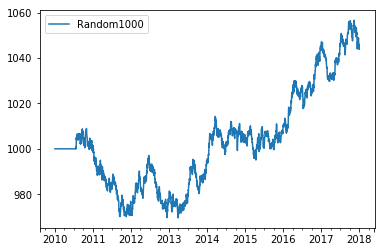

In [14]:
df_equity = rpt.series('equity')
df_equity.plot()